In [291]:
import sys, os
import cv2
import numpy as np
import warnings
from matplotlib import pyplot as plt
import math
import numpy

In [292]:
# Variables
KERNEL_SIZE = 3

In [293]:
def estimate_watermark(foldername):
    """
    (grad(W) = median(grad(J)))
    """
    if not os.path.exists(foldername):
        warnings.warn("Folder does not exist.", UserWarning)
        return None

    images = []
    for r, dirs, files in os.walk(foldername):
        # Get all the images
        for file in files:
            img = cv2.imread(os.sep.join([r, file]))
            if img is not None:
                # TODO: image must be same size, specify the (width, height)
                # img = cv2.resize(img, (512,768), interpolation = cv2.INTER_AREA)
                images.append(img)
            else:
                print("%s not found."%(file))

    # Compute gradients
    print("Computing gradients of %d images" % len(images))
    gradx = map(lambda x: cv2.Sobel(x, cv2.CV_64F, 1, 0, ksize=KERNEL_SIZE), images)
    grady = map(lambda x: cv2.Sobel(x, cv2.CV_64F, 0, 1, ksize=KERNEL_SIZE), images)

    gradx = np.array(list(gradx), dtype=object)
    grady = np.array(list(grady), dtype=object)

    # Compute median of grads
    print("Computing median gradients.")
    Wm_x = np.median(gradx, axis=0)                   
    Wm_y = np.median(grady, axis=0)

    return (Wm_x, Wm_y)

In [294]:
def PlotImage(image):
    """ 
    PlotImage: Give a normalized image matrix which can be used with implot, etc.
    Maps to [0, 1]
    """
    im = image.astype(float)
    return (im - np.min(im))/(np.max(im) - np.min(im))

In [295]:
def image_threshold(image, threshold=0.5):
    '''
    Threshold the image to make all its elements greater than threshold*MAX = 1
    '''
    m, M = np.min(image), np.max(image)
    im = PlotImage(image)
    im[im >= threshold] = 1
    im[im < 1] = 0
    return im

In [296]:
def crop_watermark(gradx, grady, threshold=0.6, boundary_size=2):
    """
    Crops the watermark by taking the edge map of magnitude of grad(W)
    Assumes the gradx and grady to be in 3 channels
    threshold - gives the threshold
    boundary_size - boundary around cropped image
    """
    gradx = gradx.astype(np.float32)
    grady = grady.astype(np.float32)

    W_mod = np.sqrt(np.square(gradx) + np.square(grady))
    # W_mod = PlotImage(W_mod)
    W_gray = image_threshold(np.average(W_mod, axis=2), threshold=threshold)
    x, y = np.where(W_gray == 1)

    xm, xM = np.min(x) - boundary_size - 1, np.max(x) + boundary_size + 1
    ym, yM = np.min(y) - boundary_size - 1, np.max(y) + boundary_size + 1
    plt.imshow(W_gray)
    return gradx[xm:xM, ym:yM, :] , grady[xm:xM, ym:yM, :]
    

    

In [297]:
crop_watermark

<function __main__.crop_watermark(gradx, grady, threshold=0.6, boundary_size=2)>

In [298]:
def watermark_detector(img, gx, gy, thresh_low=200, thresh_high=220, printval=False):
    """
    Compute a verbose edge map using Canny edge detector, take its magnitude.
    Assuming cropped values of gradients are given.
    Returns image, start and end coordinates
    """
    gx = np.array(gx, dtype=np.float64)
    gy = np.array(gy, dtype=np.float64)

    Wm = (np.average(np.sqrt(np.square(gx) + np.square(gy)), axis=2))

    img_edgemap = (cv2.Canny(img, thresh_low, thresh_high))
    chamfer_dist = cv2.filter2D(img_edgemap.astype(float), -1, Wm)

    rect = Wm.shape
    index = np.unravel_index(np.argmax(chamfer_dist), img.shape[:-1])
    if printval:
        print(index)

    x,y = (index[0]-rect[0]/2), (index[1]-rect[1]/2)
    im = img.copy()
    cv2.rectangle(im, (int(y), int(x)), (int(y+rect[1]), int(x+rect[0])), (255, 255, 255), 5)
    return(im)

Computing gradients of 11 images
Computing median gradients.


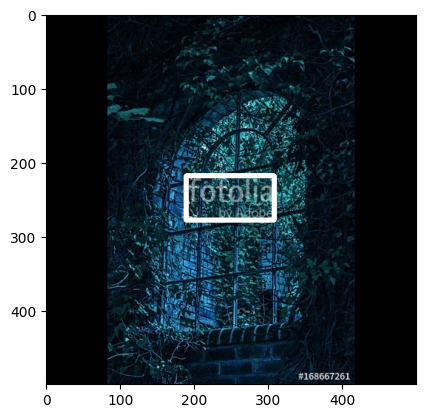

In [299]:
folder = "/content/drive/MyDrive/fotolia"
gx, gy= estimate_watermark(folder)

cropped_gx, cropped_gy = crop_watermark(gx, gy)

# random photo
sample = "/content/drive/MyDrive/testimg/fotolia_168667261.jpg"
img = cv2.imread(sample)

im= watermark_detector(img, cropped_gx, cropped_gy)

im.shape
plt.imshow(im)